<a href="https://colab.research.google.com/github/eli-suarez845/AmazonBooksReviews_NLP/blob/main/AmazonBooks_ElisaSuarez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Science III Final proyect - 2025**

# Abstract

Motivation: To make a first approach to Deep Learning, by means of Natural Language Processing and Neural Networks.

Objectives:


*   To select a text corpus and apply preprocessing techniques of NLP, such as tokenization, lemmatization, normalization and stopwords removal.
*   To make a Sentiment Analysis with TF-IDF vectorizer and to evaluate the polarity of some phrases.
*   To generate at least three insights.
*   To train a convolutional neural network

# **Exploratory Data Analysis**

First let's import the libraries we are going to use.

In [16]:
%%time
import gzip
import json
import string

import spacy
import nltk
import pandas as pd
import numpy as np
import plotly
import matplotlib.pyplot as plt
import os
nltk.download('punkt')

from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import numpy as np

CPU times: user 4.35 s, sys: 1.15 s, total: 5.49 s
Wall time: 11.7 s


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Connecting to the web to extract the dataset.



In [4]:
file_path = "Books.jsonl.gz"

if not os.path.exists(file_path):
    !wget --no-check-certificate https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/review_categories/Books.jsonl.gz
else:
    print("El archivo ya existe, no es necesario descargarlo nuevamente.")

--2025-03-19 19:41:16--  https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/review_categories/Books.jsonl.gz
Resolving mcauleylab.ucsd.edu (mcauleylab.ucsd.edu)... 169.228.63.88
Connecting to mcauleylab.ucsd.edu (mcauleylab.ucsd.edu)|169.228.63.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6216820644 (5.8G) [application/gzip]
Saving to: ‘Books.jsonl.gz’

Books.jsonl.gz      100%[===================>]   5.79G  24.8MB/s    in 3m 58s  

2025-03-19 19:45:15 (24.9 MB/s) - ‘Books.jsonl.gz’ saved [6216820644/6216820644]



Reading the extracted json file.

It consists of Amazon Books reviews, with the reviews and ratings made by users for their purchases.

In [5]:
# Reading the text in chunks
amazon_reviews_iter = pd.read_json(
    '/content/Books.jsonl.gz',
    lines=True,
    compression='gzip',
    chunksize=10000
)
# Processing a single chunk as an example
for chunk in amazon_reviews_iter:
    data = chunk
    print(data.head())
    break

   rating                                              title  \
0       1      Not a watercolor book! Seems like copies imo.   
1       5  Updated: after 1st arrived damaged this one is...   
2       5                              Excellent! I love it!   
3       5       Updated after 1st arrived damaged. Excellent   
4       5                                Beautiful patterns!   

                                                text  \
0  It is definitely not a watercolor book.  The p...   
1  Updated: after first book arrived very damaged...   
2  I bought it for the bag on the front so it pai...   
3  Updated: after 1st arrived damaged the replace...   
4  I love this book!  The patterns are lovely. I ...   

                                              images        asin parent_asin  \
0  [{'small_image_url': 'https://m.media-amazon.c...  B09BGPFTDB  B09BGPFTDB   
1                                                 []  0593235657  0593235657   
2                                     

If we wanted to read all the reviews, we could use this code. We don't do it because of available resources.

            amazon_reviews_list = []

            for chunk in amazon_reviews_iter:
              amazon_reviews_list.append(chunk)

            df = pd.concat(amazon_reviews_list, ignore_index=True)
            print(df.shape)

We convert the file into a pandas DataFrame to work with it.

In [6]:
df = pd.DataFrame(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   rating             10000 non-null  int64         
 1   title              10000 non-null  object        
 2   text               10000 non-null  object        
 3   images             10000 non-null  object        
 4   asin               10000 non-null  object        
 5   parent_asin        10000 non-null  object        
 6   user_id            10000 non-null  object        
 7   timestamp          10000 non-null  datetime64[ns]
 8   helpful_vote       10000 non-null  int64         
 9   verified_purchase  10000 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 713.0+ KB


The dataframe has 10 columns, there are no null values.

In [7]:
df.columns

Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase'],
      dtype='object')

Dataset columns:

* rating: score (1-5)
* title: review title
* text: review written by user
* images: small book cover
* asin: book id
* user_id: user identifier
* timestamp: when the review was created
* helpful_vote: total number of people who have given an indication of whether the review has been useful or not
* verified_purchase: whether or not the user actually purchased the book in Amazon (True of False)


Dropping not relevant columns for this analysis, we don't care who wrote the reviews, just what is written

In [8]:
df.drop(["parent_asin", "images", "asin", "user_id"], axis=1, inplace=True)

In [9]:
df

,rating,title,text,timestamp,helpful_vote,verified_purchase
0,1,Not a watercolor book! Seems like copies imo.,It is definitely not a watercolor book. The p...,2022-01-17 06:06:38.485,0,True
1,5,Updated: after 1st arrived damaged this one is...,Updated: after first book arrived very damaged...,2021-12-27 18:26:44.904,1,True
2,5,Excellent! I love it!,I bought it for the bag on the front so it pai...,2021-12-24 22:04:55.102,0,True
3,5,Updated after 1st arrived damaged. Excellent,Updated: after 1st arrived damaged the replace...,2021-12-24 16:55:06.602,0,False
4,5,Beautiful patterns!,I love this book! The patterns are lovely. I ...,2021-11-19 08:57:33.230,0,True
...,...,...,...,...,...,...
9995,5,A well researched book of facts and accomplish...,"This book is a short, compressed look at the l...",2019-11-27 03:36:46.573,0,False
9996,5,An enjoyable book of wisdom and encouragement,This is a charming book written by a smart wom...,2019-11-25 04:17:50.598,0,False
9997,5,An enchanting book,I completely enjoyed this short look into the ...,2019-10-28 20:38:22.752,0,False
9998,5,Amazing detail and a bounty of information,This is a great deal of necessary information ...,2019-10-13 22:39:41.867,4,False


Let's convert timestamp to Datetime, in order to drop hours and minutes.

In [10]:
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.floor('d')

print(df['timestamp'].head(5))

0   2022-01-17
1   2021-12-27
2   2021-12-24
3   2021-12-24
4   2021-11-19
Name: timestamp, dtype: datetime64[ns]


Now, we can count how many reviews were made per day.

For example, in September 2012, 54 reviews were made

In [11]:
df.timestamp.value_counts()

,count
timestamp,
2012-09-17,54
2008-03-14,31
2020-01-15,27
2016-07-25,23
2021-01-31,23
...,...
2021-07-13,1
2021-07-30,1
2021-08-11,1


# Number of reviews per year

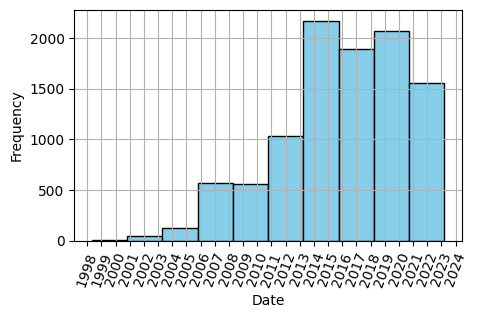

In [43]:
import matplotlib.dates as mdates
df['timestamp'].hist(bins=10,
                     figsize=(5, 3),
                     color='skyblue', edgecolor='black')
plt.xlabel("Date")
plt.ylabel("Frequency")

# Rotate labels for better readability
plt.xticks(rotation=70)

# Adjust the format of the dates on the X-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Sample each year
plt.show()

We see how from 2013 to 2021 there were a large number of reviews per year.

# Ratings

How many reviews are in each category?

In [44]:
df.rating.value_counts()

,count
rating,
5,5827
4,2597
3,1066
2,360
1,150


Let's convert the count to percentages.

In [45]:
percent_val = 100 * df.rating.value_counts()/df.shape[0]
percent_val

,count
rating,
5,58.27
4,25.97
3,10.66
2,3.60
1,1.50


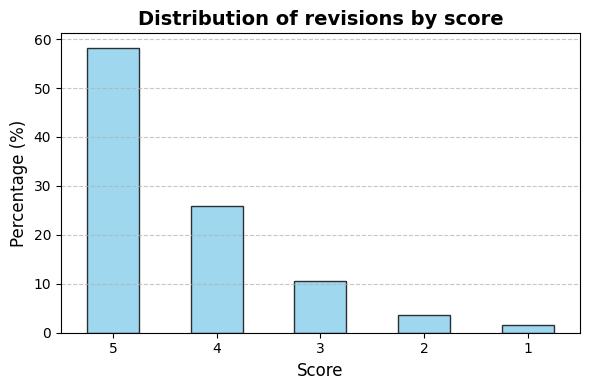

In [46]:
# Create the bar chart
plt.figure(figsize=(6, 4))
percent_val.plot.bar(color='skyblue', edgecolor='black', alpha=0.8)

# Add title and tags with optimized sizes
plt.title('Distribution of revisions by score', fontsize=14, fontweight='bold')
plt.xlabel('Score', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)

# Customize x-axis labels
plt.xticks(rotation=0, fontsize=10)

# Add grid to improve readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust margins
plt.tight_layout()

# Show the graph
plt.show()


The distribution is asymmetrical, reflecting that 58.27 % of rating 5 and 1.5 of rating 1.

# Useful Votes per Year

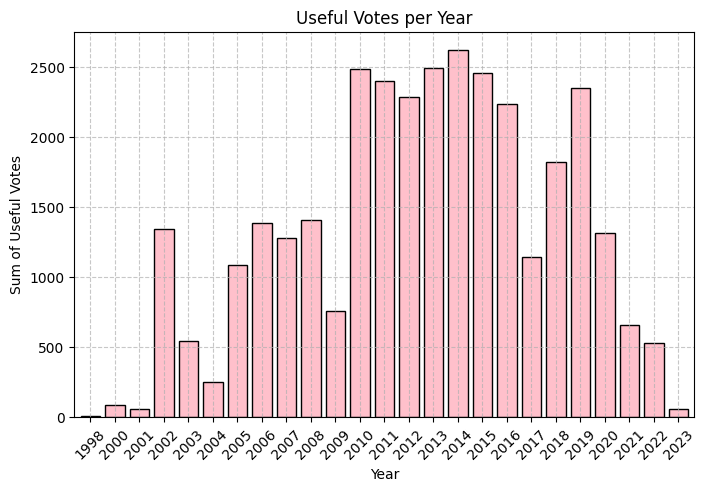

In [47]:
# Extract only the year
df['year'] = df['timestamp'].dt.year

# Group by year and add the useful votes.
votes_per_year = df.groupby('year')['helpful_vote'].sum()

# Create the bar chart
plt.figure(figsize=(8, 5))
votes_per_year.plot(kind='bar', color='pink', edgecolor='black', width=0.8)

# Use plt.gca() to get the current axis and activate the grid.
ax = plt.gca()  # Get current axis
ax.grid(True, linestyle='--', alpha=0.7)  # Activate grid with style

# Adjust labels and display graphic
plt.xlabel("Year")
plt.ylabel("Sum of Useful Votes")
plt.title("Useful Votes per Year")
plt.xticks(rotation=45)

plt.show()

However, users found the reviews really useful from 2010 to 2016, and then again in 2019 (pre-pandemic, interesting, right?).






# Wordcloud graph

In [48]:
df['text']

,text
0,It is definitely not a watercolor book. The p...
1,Updated: after first book arrived very damaged...
2,I bought it for the bag on the front so it pai...
3,Updated: after 1st arrived damaged the replace...
4,I love this book! The patterns are lovely. I ...
...,...
9995,"This book is a short, compressed look at the l..."
9996,This is a charming book written by a smart wom...
9997,I completely enjoyed this short look into the ...
9998,This is a great deal of necessary information ...


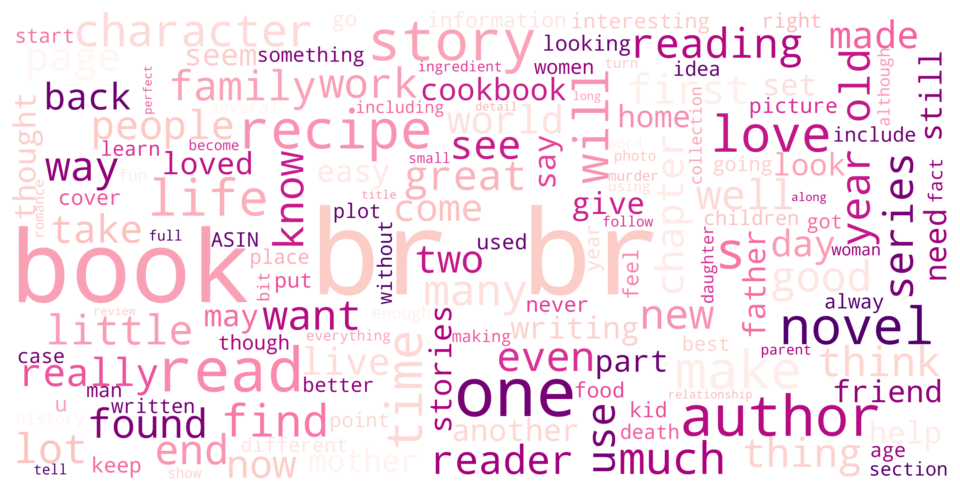

In [49]:
# WordCloud configuration
from wordcloud import WordCloud
text = df['text'].str.cat(sep=' ')
wordcloud = WordCloud(
    max_font_size=100,
    max_words=150,
    background_color="white",
    scale=5,
    width=800,
    height=400,
    colormap='RdPu' # Colormap for more attractive colors
).generate(text)

# Show
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.show()

# NLP pre-processing

# Normalization

 First let's change everything to lower case, so is easier for the model to understand the corpus.

In [12]:
df['reviews_text_new'] = df.text.apply(lambda x: x.lower())

Now let's remove the special characters from the reviews.

In [13]:
#  Selecting the non-alpha-numeric characters that are not spaces
special_chars = df.reviews_text_new.apply(lambda x: [each for each in list(x) if not each.isalnum() and each != ' '])

# Obtain a list of lists
flat_list = [item for sublist in special_chars for item in sublist]
print(set(flat_list))

df['reviews_text_new'] = df.reviews_text_new.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

{'@', '”', '⭐', '&', '✅', '~', '―', ']', '…', '¡', '🏀', '<', '\xa0', '👏', '🚴', '�', '→', '😱', '°', '÷', '*', '🛒', '👦', '😳', ';', '>', '’', '✔', '📕', '‘', '👄', '☀', '.', '🥱', '💉', '😄', '$', '=', '👌', '\u2028', '#', '`', ')', '?', '\u200d', '😜', '🏽', '☺', '🐝', '😬', '[', '®', '🦋', '\xad', '♟', ':', '😍', '|', '“', '\u200e', '{', '–', '💙', '✋', '🥳', '⚠', '−', '·', '—', '😉', '•', '⁄', '\u200b', '%', '!', '😆', '😁', '👍', '}', '(', '\\', '♀', '\u2029', '❤', '-', '+', '"', '💖', '/', '️', "'", '🏻', '🌟', '😮', '_', ',', '\uf076', '©', '😂', '😢', '\u2009'}


# Tokenization

Tokenization is the process of breaking a text into smaller units, known as tokens, usually words or punctuation marks, which can be useful for analyzing how certain textual transformations affect lexical diversity in the data.

In [14]:
from nltk.tokenize import word_tokenize

try:
    nltk.download('punkt')
    nltk.download('punkt_tab')
    nltk.download('averaged_perceptron_tagger')  # For POS labeling if necessary
except Exception as e:
    print(f"Error when downloading nltk resources: {e}")

# Tokenizing amazon_reviews texts
try:
    token_lists = [word_tokenize(each) for each in df.text]
    tokens = [item for sublist in token_lists for item in sublist]
    print("Number of unique tokens before: ", len(set(tokens)))

    token_lists_lower = [word_tokenize(each) for each in df.reviews_text_new]
    tokens_lower = [item for sublist in token_lists_lower for item in sublist]
    print("Number of new unique tokens: ", len(set(tokens_lower)))
except LookupError as e:
    print(f"NLTK resource search error: {e}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Number of unique tokens before:  78366
Number of new unique tokens:  71523


# Stopwords

Stop words are common words that are not considered to be relevant to the meaning of a text. They are often excluded from search indexes to improve the accuracy of search results.

In [27]:
nltk.download('stopwords')

noise_words = []
stopwords_corpus = nltk.corpus.stopwords
eng_stop_words = stopwords_corpus.words('english')
noise_words.extend(eng_stop_words)
print(len(noise_words))
noise_words

[nltk_data] Downloading package stopwords to /root/nltk_data...


198


[nltk_data]   Unzipping corpora/stopwords.zip.


['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

Let's find the high and low frequency words, which we will define as the 1% of words that appear most frequently in the reviews, as well as the 1% of words that appear least frequently in the reviews (after adjusting for case and special characters).

In [28]:
import string
from collections import Counter

# Define tokens to be deleted: all punctuation marks and 'br'.
tokens_a_eliminar = list(string.punctuation) + ['br']

# Filter the list of tokens, deleting those in tokens_to_delete
tokens_filtrados = [token for token in tokens if token not in tokens_a_eliminar]

# Calculate 1% of unique tokens
one_percentile = int(len(set(tokens_filtrados)) * 0.01)

In [30]:
# Obtain the most common tokens in that 1%.
top_1_percentile = Counter(tokens_filtrados).most_common(one_percentile)
top_1_percentile[:10]

[('the', 88396),
 ('and', 62763),
 ('a', 52922),
 ('of', 46991),
 ('to', 45558),
 ('is', 34377),
 ('I', 29776),
 ('in', 29404),
 ('that', 19366),
 ('for', 18747)]

In [31]:
# And the least common tokens in that 1%.
bottom_1_percentile = Counter(tokens_filtrados).most_common()[-one_percentile:]
bottom_1_percentile[:10]

[('Samba', 1),
 ('HTTP', 1),
 ('ssh', 1),
 ('rebooted', 1),
 ('RHCE.', 1),
 ('Administrator', 1),
 ('excelling', 1),
 ('disagreement.', 1),
 ('omit.', 1),
 ('nice-to-have', 1)]

In [32]:
noise_words.extend([word for word,val in top_1_percentile])
noise_words.extend([word for word,val in bottom_1_percentile])

In [33]:
# Filtrar palabras no deseadas en el texto
def remove_noise_words(text, noise_words):
    words = text.split()  # Tokenizar por espacios
    filtered_text = " ".join([word for word in words if word not in noise_words])
    return filtered_text

# Aplicar a la columna de texto
df["text_clean"] = df["text"].apply(lambda x: remove_noise_words(x, noise_words))

Stopwords and high/low frequency words have now been added to noise_words, which will be removed from the revisions before training the model.

# Sentiment analysis

1) Sentiment analysis with VADER:
SentimentIntensityAnalyzer is used to obtain a composite score of each review in the text column, classifying it as 'positive', 'neutral' or 'negative'.

2) Mapping ratings to sentiment:
The map_rating_to_sentiment function is defined to convert numeric values (1 to 5) into sentiment categories.

3) Comparison:
We use pd.crosstab to generate a table showing the distribution of reviews according to the sentiment based on the rating and the sentiment obtained from the text. This allows to see, for example, how many reviews with a “positive” rating (4 or 5) were classified as “positive”, “neutral” or “negative” by the VADER analysis.

In [34]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download the VADER lexicon
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def classify_sentiment(text):
    scores = sia.polarity_scores(text)
    compound = scores['compound']
    # common thresholds are:
    #           compound >= 0.05 -> positive sentiment.
    #           compound <= -0.05 -> negative sentiment
    #           all else -> neutral
    if compound >=  0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# We apply the function to the column 'text' to create a new sentiment column
df['sentiment'] = df['text_clean'].apply(classify_sentiment)

# We show the count for each category
print(df['sentiment'].value_counts())


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


sentiment
positive    6515
negative    2289
neutral     1196
Name: count, dtype: int64


In [35]:
# This function takes the rating and converts it into a sentiment category.
def map_rating_to_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

df['rating_sentiment'] = df['rating'].apply(map_rating_to_sentiment)

# Comparing both columns with a contingency table
comparison = pd.crosstab(df['rating_sentiment'], df['sentiment'])
print(comparison)

sentiment         negative  neutral  positive
rating_sentiment                             
negative               249       56       205
neutral                392       82       592
positive              1648     1058      5718


Axes(0.125,0.11;0.775x0.77)


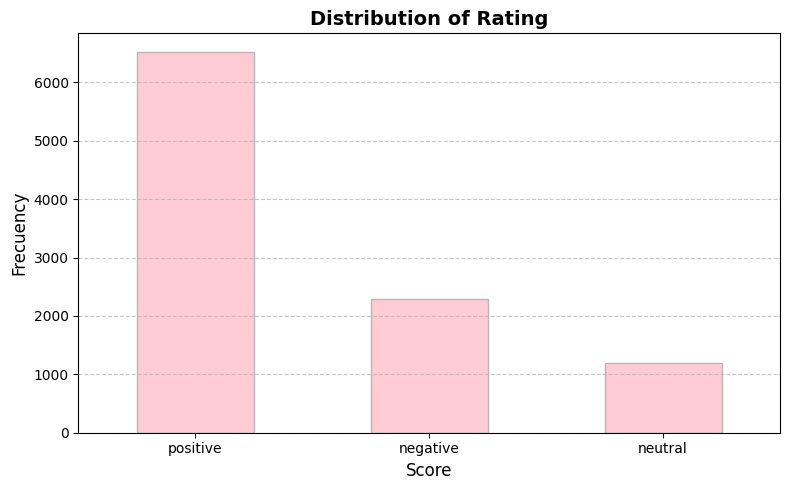

In [36]:
plt.figure(figsize=(8, 5))

# Create the bar chart
print(df['sentiment'].value_counts().plot.bar(
    color='pink',
    edgecolor='darkgrey',
    alpha=0.8               # Transparency for a smoother effect
))


plt.title('Distribution of Rating', fontsize=14, fontweight='bold')
plt.xlabel('Score', fontsize=12)               # Add title and tags
plt.ylabel('Frecuency', fontsize=12)
plt.xticks(rotation=0, fontsize=10)            # Customization of x-axis labels
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid on Y-axis to improve readability
plt.tight_layout()                             # Adjust margins and presentation
plt.show()                                     # Show graph

# Convolutional Network:

**TF-IDF: Book Ratings**

This code trains a neural network to predict book ratings using TF-IDF (Term Frequency - Inverse Document Frequency):

A technique used to evaluate the importance of a word in a document within a collection or corpus of documents.

Network architecture:

Input: TF-IDF vectors (a matrix where each row represents a review and each column, a relevant word).
Hidden layers: Several dense layers to learn relationships in the data.
Output: A single neuron with linear activation (to predict continuous ratings).
Metric: We will use RMSE (root mean square error) to measure performance.

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow import keras
from tensorflow.keras import layers

In [38]:
# Split the dataset into training and test data using columns 'text' and 'rating'.
X_text = df["text"].astype(str)
y = df["rating"].astype(float)

# Convert text to TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Using the 5000 most relevant words
X_tfidf = vectorizer.fit_transform(X_text).toarray()

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [39]:
# Resize X_train and X_test to be suitable for convolutional layers
# We must add an extra dimension to make it compatible with Conv1D.
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Convolutional neural network construction
model = keras.Sequential([
    # 1D convolutional layer with 128 filters, kernel size 3, ReLU activation
    layers.Conv1D(128, 3, activation="relu", input_shape=(X_train.shape[1], 1)),
    # Max-pooling layer to reduce dimensions
    layers.MaxPooling1D(2),
    # 1D convolutional layer with 64 filters, kernel size 3
    layers.Conv1D(64, 3, activation="relu"),
    # Another layer of max-pooling
    layers.MaxPooling1D(2),
    # 1D convolutional layer with 32 filters, kernel size 3
    layers.Conv1D(32, 3, activation="relu"),
    # Max-pooling layer
    layers.MaxPooling1D(2),
    # Flatten the output of the convolutional layers to connect it with the dense layers.
    layers.Flatten(),
    # Dense layer with 128 neurons and ReLU activation
    layers.Dense(128, activation="relu"),
    # Dropout to avoid overfitting
    layers.Dropout(0.3),
    # Linearly activated output layer for continuous prediction
    layers.Dense(1, activation="linear")
])

# Compile the model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Adding EarlyStopping to avoid overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Model training
epochs = 10
batch_size = 32
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 281s 1s/step - loss: 2.6698 - mae: 1.1824 - val_loss: 0.6670 - val_mae: 0.6298
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - loss: 0.8237 - mae: 0.7075 - val_loss: 0.6761 - val_mae: 0.6679
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 263s 845ms/step - loss: 0.7971 - mae: 0.6988 - val_loss: 0.7401 - val_mae: 0.7196
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 213s 852ms/step - loss: 0.7339 - mae: 0.6780 - val_loss: 0.6504 - val_mae: 0.5897
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 268s 874ms/step - loss: 0.7100 - mae: 0.6645 - val_loss: 0.6162 - val_mae: 0.6042
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 256s 851ms/step - loss: 0.6136 - mae: 0.6178 - val_loss: 0.7419 - val_mae: 0.7061
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 264s 861ms/step - loss: 0.6116 - mae: 0.6196 - val_loss: 0.6389 - val_mae: 0.6156
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 265s 870ms/step - loss: 0.5483 - mae: 0.5883 - val_loss: 0.6682 - val_mae: 0.6452
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s

Test MAE: 0.6042212247848511

In [40]:
# If the predicted values are close to the actual values, it means that the network is working well.

y_pred = model.predict(X_test)
y_pred = np.round(y_pred)  # Rounded to compare with actual ratings

df_results = pd.DataFrame({"Real": y_test, "Predicho": y_pred.flatten()})
print(df_results.sample(10))


63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step
      Real  Predicho
5269   5.0       5.0
1175   5.0       4.0
9030   5.0       4.0
1402   4.0       4.0
3023   5.0       5.0
7036   5.0       4.0
2474   5.0       5.0
7216   5.0       4.0
8466   5.0       5.0
496    5.0       5.0


Visualización de **Errores**

<ipython-input-45-cb4d69d89cfc>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.yticks(ticks=range(int(min(y_pred)), int(max(y_pred)) + 1))


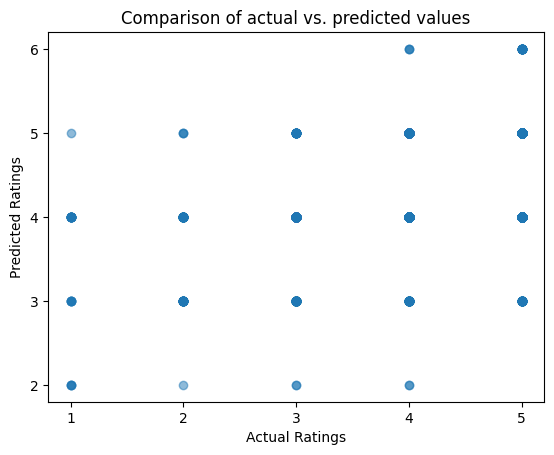

In [45]:
# Ideally, the points should line up on the y = x diagonal.
# If there is too much scatter, the model could be failing.

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Comparison of actual vs. predicted values")

# Force axis labels to integers without decimals
plt.xticks(ticks=range(int(min(y_test)), int(max(y_test)) + 1))
plt.yticks(ticks=range(int(min(y_pred)), int(max(y_pred)) + 1))

plt.show()


# Conculsions

**The model is working correctly.**

**Why use a convolutional network?**

Convolutional networks are effective in detecting local patterns in text sequences, such as combinations of relevant words or phrases that may be indicative of a high or low rating. Max-pooling layers help to reduce the dimension of the data and keep the most relevant features.

**Disadvantages vs. Dense Network:**

Convolutional layers require more computations and parameters, especially if you use many filters and large kernel sizes. This increases computational complexity, which can result in longer training times and higher hardware requirements (such as more memory and processing power).

**When to use convolutional networks?**


Convolutional networks are most effective when you are working with spatial data (such as images) or data that has important local relationships (such as text like this case or sequences). And when the dataset is large and can take advantage of the ability of CNNs to learn complex local patterns.